# K-MEANS MODEL: SEXUAL DIMORPHISM AMONG PENGUINS

Thanks for reviewing my project, featuring labwork from the Google Advanced Data Analytics program!

I made a K-means model to cluster data from a dataset that includes datapoints across a sample size of 345 penguins, such as species, island, and sex, as they relate to a study by PLOS ONE of sexual dimorphism among penguins (essentialy, physical differences between males and females of the same species).

What is the point of clustering this data? Primarily to demonstrate k-means in action, but also to use unsupervised machine learning to provide the foundation for deeper analysis--it's essentially a starting point.  

The results of my k-means model demonstrated differentiable clusters by both sex and species, with stronger clustering in sex of penguins.  Ultimately, we have more definitive sense of patterns and relationships in the data (sex, for example) that we might not be necessarily be able to ascertain with our naked eye.

Have a look!

## **IMPORTS** 


In [6]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sn


In [7]:
# import CSV data
penguins = pd.read_csv("../datasets/penguins.csv")

In [8]:
# display data
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female


## EDA

In [9]:
# penguin species using .unique() method
penguins['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [10]:
# species counts using .value_counts() method
penguins['species'].value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

There are 152 Adelie, 124 Gentoo, and 68 Chinstrap species.  To take it one step further, I would also designate and quantify the type of these penguins by both their species as well as their origin island (i.e. "Torgersen Adelie").  It's possible each species is unique to its respective island, but that's why it would be good to designate them this way--to isolate any potential anomolies. 

Why is it helpful to determine the perfect number of clusters using K-means when we already know how many penguin species the dataset contains?

True metrics of evaluating K-Means efficacy, such as inertia, silhouette score, and the like, will render the best and most mathematically precise analysis of the optimum number of clusters to use.  Whereas, if we were to just select clusters based on what we perceived to be the optimum number of clusters, the math may disqualify our human guess.  Who knows...maybe there are other variables at work that will alter the clustering in a surprising way.

### DROP MISSING VALUES

An assumption of K-means is that there are no missing values. 

In [11]:
# check for missing values using .isnull().sum() 
penguins.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [12]:
# drop rows with missing values and save DataFrame to new variable
penguins_subset = penguins.dropna(axis=0).reset_index(drop = True)

In [13]:
# double-check for missing values
penguins_subset.isnull().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [14]:
# view new dataset
penguins_subset.head(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male
5,Adelie,Torgersen,38.9,17.8,181.0,3625.0,female
6,Adelie,Torgersen,39.2,19.6,195.0,4675.0,male
7,Adelie,Torgersen,41.1,17.6,182.0,3200.0,female
8,Adelie,Torgersen,38.6,21.2,191.0,3800.0,male
9,Adelie,Torgersen,34.6,21.1,198.0,4400.0,male


## ENCODING 


In [15]:
# use .str.upper() to grab the designated string values and make them upper case
penguins_subset['sex'] = penguins_subset['sex'].str.upper()
penguins_subset['sex']

0        MALE
1      FEMALE
2      FEMALE
3      FEMALE
4        MALE
        ...  
328    FEMALE
329    FEMALE
330      MALE
331    FEMALE
332      MALE
Name: sex, Length: 333, dtype: object

K-means needs numeric columns for clustering, so I'll convert the categorical column `'sex'` to numeric. There is no need to convert the `'species'` column because it isn't being used as a feature in the clustering algorithm. 

In [16]:
# convert `sex` column from categorical to numeric with .get_dummies()
penguins_subset = pd.get_dummies(data = penguins_subset, drop_first = True, columns=['sex'])
penguins_subset.head()

## NOTE: where sex_MALE is zero, that simply means the sex is female.

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_MALE
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,1
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,0
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,0
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,1


### DROP USELESS FEATURES

This notebook is trying to confirm if penguins of the same species exhibit different physical characteristics based on sex. This doesn't include location, so I'll drop `'island'`. 

In [17]:
# drop the island column.
penguins_subset = penguins_subset.drop('island',axis=1)

In [18]:
penguins_subset.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_MALE
0,Adelie,39.1,18.7,181.0,3750.0,1
1,Adelie,39.5,17.4,186.0,3800.0,0
2,Adelie,40.3,18.0,195.0,3250.0,0
3,Adelie,36.7,19.3,193.0,3450.0,0
4,Adelie,39.3,20.6,190.0,3650.0,1


### SCALING

Because K-means uses distance between observations as its measure of similarity, it's important to scale the data before modeling. Scikit-Learn's `StandardScaler` scales each point by subtracting the mean observed value for that feature and dividing by the standard deviation.  This ensures that all variables have a mean of 0 and variance/standard deviation of 1. Scaling categorical data isn't applicable, so I'll create a new dataframe ('X') without it.

In [19]:
# exclude `species` variable from new dataframe X
X = penguins_subset.drop('species',axis=1)
X.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_MALE
0,39.1,18.7,181.0,3750.0,1
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,36.7,19.3,193.0,3450.0,0
4,39.3,20.6,190.0,3650.0,1


Scale the features in `X` using `StandardScaler`, and assign the scaled data to a new variable `X_scaled`. 

In [20]:
# scale features using StandardScaler().fit_transform() and assign to variable `X_scaled`.
X_scaled = StandardScaler().fit_transform(X)
X_scaled

array([[-0.89604189,  0.7807321 , -1.42675157, -0.56847478,  0.99103121],
       [-0.82278787,  0.11958397, -1.06947358, -0.50628618, -1.00904996],
       [-0.67627982,  0.42472926, -0.42637319, -1.1903608 , -1.00904996],
       ...,
       [ 1.17338426, -0.74499437,  1.50292796,  1.91906927,  0.99103121],
       [ 0.22108196, -1.20271231,  0.78837197,  1.23499466, -1.00904996],
       [ 1.08181673, -0.54156417,  0.85982757,  1.48374906,  0.99103121]])

## **MODELING** 

To start, I'll write a function `kmeans_inertia` that takes `num_clusters` and `x_vals` (`X_scaled`) and takes a list of computed inertia for the purpose of determining clusters.

In [21]:
# fit K-means and evaluate inertia for different values of k for i in range 2-11 (num_clusters)
num_clusters = [i for i in range(2,11)]

# function kmeans_inertia
def kmeans_inertia(num_clusters, x_vals):
    inertia = [] # list to return iterables (inertia)
    for num in num_clusters: # iterate and run for loop for num_clusters input variable
        kms = KMeans(n_clusters=num,random_state=42) # syntax for KMeans(n_clusters,random_state)
        kms.fit(x_vals) # after setting KMeans variable, run .fit(x_vals input variable)
        inertia.append(kms.inertia_) # run inertia method using syntax kms.inertia_
    
    return inertia

Use the `kmeans_inertia` function to return a list of inertia for k=2 to 10.

In [22]:
# run kmeans_inertia helper function for num_clusters with X_scaled array
inertia = kmeans_inertia(num_clusters,X_scaled)
inertia

[885.6224143652249,
 578.8284278107235,
 386.14534424773285,
 284.5464837898288,
 217.92858573807678,
 201.39287843423264,
 186.82270634899209,
 173.47283154242746,
 164.55854201979943]

One key method to ascertain k-means clusters is to create a line plot that shows the relationship between `num_clusters` and `inertia` and employ the "elbow method"--essentially, we're looking for the obvious "elbow" point in the graph to visually determine the point after which additional clusters do not reduce the inertia score.

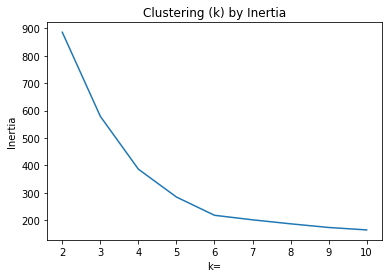

In [23]:
# seaborn lineplot of num_clusters vs. inertia to employ the elbow method
sn.lineplot(x=num_clusters,y=inertia);

# labeling 
plt.title('Clustering (k) by Inertia')
plt.xlabel('k=')
plt.ylabel('Inertia')
plt.show();

Using the elbow method, it appears the optimum k value is 6 (6 clusters).

## **RESULTS & EVALUATION** 

Silhouette scores are used to study the distance between clusters and can be computed using the `silhouette_score()` function. 

Here, I'll compare the silhouette score of each value of k, from 2 through 10 with a helper function `kmeans_sil` that takes `num_clusters` and `x_vals` (`X_scaled`) and returns a list of each k-value's silhouette score.

In [24]:
# evaluate silhouette score with a helper function
def kmeans_sil(num_clusters, x_vals):
    sil_score = [] # list to return iterables (silhouette scores)
    for num in num_clusters: # iterate and run for loop for num_clusters input variable
        kms = KMeans(n_clusters=num, random_state=42) # syntax for KMeans(n_clusters,random_state)
        kms.fit(x_vals) # after setting KMeans variable, run .fit(x_vals input variable)
        sil_score.append(silhouette_score(x_vals, kms.labels_)) # append silhouette scores, computed with silhouette_scre(x_vals,kms.labels_)
        
    return sil_score

Next, create a line plot that shows the relationship between `num_clusters` and `sil_score`.
Use either seaborn or matplotlib to visualize this relationship. 

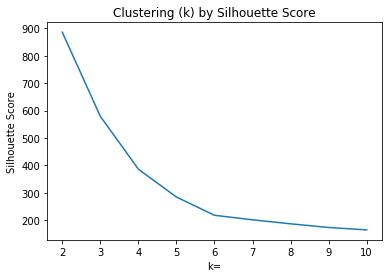

In [25]:
# run function to get silhouette scores for scaled data X_scaled
sil_score = kmeans_inertia(num_clusters,X_scaled)
sil_score

# seaborn line plot of silhouette scores and clusters
sn.lineplot(x=num_clusters,y=sil_score)

# labeling 
plt.title('Clustering (k) by Silhouette Score')
plt.xlabel('k=')
plt.ylabel('Silhouette Score')
plt.show();

When I ran the elbow method on silhouette scores, it agrees with our previous observation k=6 (i.e. 6 clusters are optimal for this model).

### OPTIMAL K-VALUE

To decide on an optimal k-value, I'll fit a six-cluster model to the dataset. 

In [26]:
# fit 6-cluster model to the scaled data
kmeans6 = KMeans(n_clusters = 6, random_state=42)
kmeans6.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

Ran some code to print out unique labels of the fit model.

In [27]:
# print unique labels with Numpy's .unique() method (run on kmeans6.labels_)
print('Unique labels:', np.unique(kmeans6.labels_))

Unique labels: [0 1 2 3 4 5]


The next step is to index these clusters into the original, unscaled dataset (it's better to use unscaled data because it's easier to interpret).  I'll add a new column for this purpose.

In [28]:
# create a new column `cluster` to index the clusters
penguins_subset['cluster'] = kmeans6.labels_
penguins_subset.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_MALE,cluster
0,Adelie,39.1,18.7,181.0,3750.0,1,0
1,Adelie,39.5,17.4,186.0,3800.0,0,2
2,Adelie,40.3,18.0,195.0,3250.0,0,2
3,Adelie,36.7,19.3,193.0,3450.0,0,2
4,Adelie,39.3,20.6,190.0,3650.0,1,0


Next step is to gather insights from the clusters. I'll use .groupby() to verify if any cluster can be differentiated by species.

In [29]:
# group cluster and species by size
penguins_subset.groupby(by=['cluster','species']).size()

cluster  species  
0        Adelie       71
1        Gentoo       58
2        Adelie       73
         Chinstrap     5
3        Gentoo       61
4        Adelie        2
         Chinstrap    34
5        Chinstrap    29
dtype: int64

Below is visualization (bar plot) representing cluster size by species.

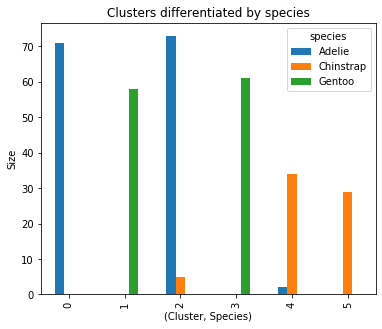

In [30]:
# visulization: clustering of species
penguins_subset.groupby(by=['cluster', 'species']).size().unstack().plot.bar(
    title='Clusters differentiated by species',
    figsize=(6, 5)
)
plt.xlabel('(Cluster, Species)')
plt.ylabel('Size')
plt.show()

I'll try the same thing with species and sex features.

In [31]:
# verify if each `cluster` can be differentiated by `species' AND `sex_MALE`
penguins_subset.groupby(by=['cluster', 'sex_MALE']).size()

cluster  sex_MALE
0        1           71
1        0           58
2        0           78
3        1           61
4        1           36
5        0           29
dtype: int64

It appears that the clusters are differentiable by sex.

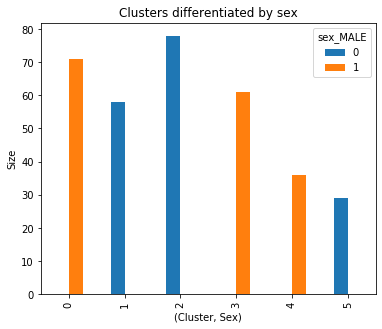

In [32]:
# visulization: clustering of sex
penguins_subset.groupby(by=['cluster', 'sex_MALE']).size().unstack().plot.bar(
    title='Clusters differentiated by sex',
    figsize=(6, 5)
)
plt.xlabel('(Cluster, Sex)')
plt.ylabel('Size')
plt.show()

## **CONSIDERATIONS/RESULTS**

* The general process of creating a meaningful clustering algorithm involves: EDA, removing null values, removing unnecessary columns, encoding, scaling, writing functions to train data with KMeans inertia and silhouette scores, visually representing inertia and silhouette score to spitball the k-value, running KMeans on the optimum k-value, and then validating the clusters
* Data can be scaled by taking the value of each point, minus its average, divided by the standard deviation (x-scaled = (xᵢ – mean(X)) / σ) --> the simplest method to do this is to run Scikit-Learn's StandardScaler()
* In order to run StandardScaler() method on data, you have to pass the dataset to .fit_transform() method --> StandardScaler().fit_transform(X) 
* In order to run KMeans on the data, one great method is to create a function, which involves: creating the iterable, defining the function with two variables (the iterable and the training data), an array, a for loop to run KMeans through on the iterable, setting a variable for KMeans(n_clusters=n), running .fit(x_vals) to fit the KMeans variable to the training data, and then appending the inertia/silhouette score values to the array
* KMeans let's you run .inertia_ as a method, but silhouette_score requires you to input two variables --> the training data as well as KMeans.labels_
* Once you understand what appears to be the most optimum k value based on elbow methodology, you can then run KMeans on n_cluster=k and then fit it to the training data (run it on scaled data!)
* In order to get the best practical use of the KMeans clusters, index them back into your non-scaled dataframe, and then use groupby and aggregation methodologies to understand what works best for clustering purposes
* All in all, the process simply involves prepping the data for modeling, then modeling, and then validating the model

To stakeholders, I would simply express that we have determined that 6 clusters are optimal for the purposes of our model, and that the model is best differentiated by sex of the penguin.  K-means modeling is a powerful unsupervised maching learning tool, but is only a first step towards uncovering underlying patterns and relationships within the data.  I would suggest that we proceed with additional modeling, testing, feature engineering, etc. on the indexed dataset (the one indexed with the clusters), such as ANOVA, regression, etc. in order to uncover more actionable insights.

Please follow link below for more information on this dataset and the corresponding study of ecological sexual dimorphism and environmental variability antartic penguin communities over at PLOS ONE.

### REFERENCES

[Gorman, Kristen B., et al. “Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus Pygoscelis).” PLOS ONE, vol. 9, no. 3, Mar. 2014, p. e90081. PLoS Journals](https://doi.org/10.1371/journal.pone.0090081)
